In [1]:
import pickle
G = pickle.load(open('week4graph.pickle', 'rb'))

num_communities:127


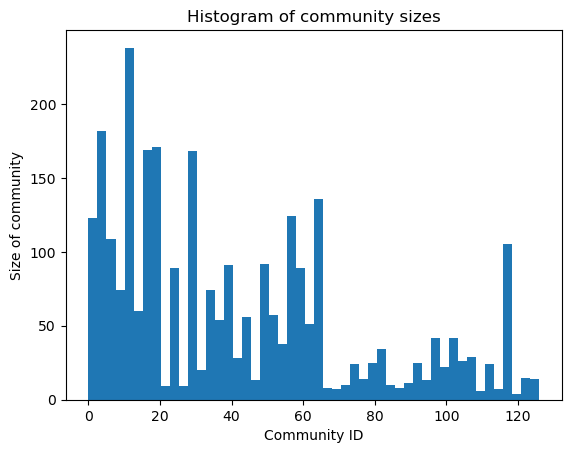

In [2]:
import community as community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import random

best_partition = community_louvain.best_partition(G)
print(f'num_communities:{max(best_partition.values())+1}')

plt.hist(best_partition.values(), bins = 50)
plt.title('Histogram of community sizes')
plt.xlabel('Community ID')
plt.ylabel('Size of community')
plt.show()


Number of communities is 125 and their sizes can be visualized in histogram above. The modularity is calculated below as 0.28. The Wald 95% CI for the expected modularity in a sampled community is 0.28 +- 0.006 but by inspecting the above histogram, it might not be reasonable to assume normality. Therefore a non-parametric boostrap with N = 1000 is calculated and a 95% CI found using quantiles 2.5% and 97.5% quantiles: [0.214, 0.353]

 Modularity is significant from 0.

In [3]:
communities = {}
for node in best_partition:
    if best_partition[node] not in communities:
        communities[best_partition[node]] = [node]
    else:
        communities[best_partition[node]].append(node)

def modularity(G, communities):
    m = G.number_of_edges()
    q = {}
    for c in communities:
        lc = len(communities[c])
        kc = sum(G.degree(n) for n in communities[c])

        q[c] = lc/m - (kc/(2*m))**2
    return q

q = sum(modularity(G, communities).values())
conf_int = 1.96 * np.std(list(modularity(G, communities).values())) #Wald 95% CI for the expected modularity in a sampled community.
print(f'bad estimate! Wald CI modularity:{q} + - {conf_int}')

#non-parametric bootstrapped modularity estimate
def bootstrap_modularity(G, communities, n):
    q = []
    for i in range(n):
        new_communities = {}
        groups = list(communities.keys())
        sample_nums = random.choices(groups, k = len(groups))
        for c in communities:
             new_communities[c] = communities[sample_nums[c]]
        q.append(sum(modularity(G, new_communities).values()))
    return q
q_boot = bootstrap_modularity(G, communities, 1000)
#quantiles. 2.5% and 97.5%
q_boot.sort()
print(f'non-parametric boostrap 95% CI for modularity: [{q_boot[25]} , {q_boot[975]}]')

bad estimate! Wald CI modularity:0.2793290685822932 + - 0.006361655790165838
non-parametric boostrap 95% CI for modularity: [0.21058215696792656 , 0.35872356805576633]


In [4]:
import json
with open('best_partition.json', 'w') as f:
        json.dump(best_partition, f)
with open('communities.json', 'w') as f:
     json.dump(communities, f)


# Part 3

In [5]:
import json, pickle
G = pickle.load(open('week4graph.pickle', 'rb'))
#load json files
with open('best_partition.json', 'r') as f:
    best_partition = json.load(f)
with open('communities.json', 'r') as f:
    communities = json.load(f)

degree_dict = dict(G.degree())

In [6]:
import nltk, pandas as pd, string
css_papers = pd.read_csv(r'C:\Users\khali\OneDrive - Danmarks Tekniske Universitet\6. semester\Computational Social Science\Computational-Social-Science-Exercises\css_df.csv')
#abstract_papers = pd.read_csv(r'C:\Users\khali\OneDrive - Danmarks Tekniske Universitet\6. semester\Computational Social Science\Computational-Social-Science-Exercises\paper_astract_df.csv',lineterminator='\n')
##All abstract rows that have a paperId that is in the css_papers dataframe
#abstract_css_df = abstract_papers[abstract_papers['paperId'].isin(css_papers['paperId'])]
##save abstract_css_df to csv
#abstract_css_df.to_csv(r'C:\Users\khali\OneDrive - Danmarks Tekniske Universitet\6. semester\Computational Social Science\Computational-Social-Science-Exercises\abstract_css_df.csv', index = False)
abstract_css_df = pd.read_csv(r'C:\Users\khali\OneDrive - Danmarks Tekniske Universitet\6. semester\Computational Social Science\Computational-Social-Science-Exercises\abstract_css_df.csv')


In [7]:
import string
#nltk.download('stopwords')
tok_list = []
bigram_list = []
bad_tokens = set(['nan','https:', 'http:', 'www.']) | set(nltk.corpus.stopwords.words('english')) | set(string.punctuation)
bad_tokens_2 = set(string.punctuation) | set(['[',']','(',')','{','}','<','>','/','\\','|',')',']'])
for i in range(len(abstract_css_df['abstract'])):
    text = abstract_css_df['abstract'].iloc[i]
    if i % 1000 == 0:
       print(i)
    tokens = nltk.word_tokenize(str(text))
    tokens = [token.lower() for token in tokens]
    remove_indexes = []
    for i in range(len(tokens)):
        #remove bad tokens
        if any([(tokens[i] == bad_token) for bad_token in bad_tokens]):
            remove_indexes.append(i)
        elif any([(bad_token in tokens[i]) for bad_token in bad_tokens_2]):
            remove_indexes.append(i)

    for i in range(len(remove_indexes) - 1, -1, -1):
        remove_index = remove_indexes[i]
        del tokens[remove_index]

    if len(tokens) == 1:
        tokens.remove(tokens[0])
    
    #create bigrams using tokens
    bigrams = list(nltk.bigrams(tokens))
    bigram_list.append(bigrams)
    tok_list.append(tokens)


0
1000
2000
3000


In [8]:
#make new token column in abstract_css_df
abstract_css_df['tokens'] = tok_list
abstract_css_df['bigrams'] = bigram_list
#abstract_css_df.to_csv(r'C:\Users\khali\OneDrive - Danmarks Tekniske Universitet\6. semester\Computational Social Science\Computational-Social-Science-Exercises\abstract_tok_df.csv', index = False)
#abstract_tok_df = pd.read_csv(r'C:\Users\khali\OneDrive - Danmarks Tekniske Universitet\6. semester\Computational Social Science\Computational-Social-Science-Exercises\abstract_tok_df.csv')

# Exercise 4

## task 1
TF-IDF is a measure for how important a token/word is in a corpus and is useful for things like information search, since it can be used as a way to weigh the importance of some words vs others. In TF-IDF, the importance measure of a word is high if the word is unique throughout the corpus, while words that occur commonly throughout the different documents in the corpus are weighted low. For example if searching for a pop song using a snippet of lyrics in a corpus containing pop song lyrics, querying the tokens: ["love", "you" ,"potato"], it intuitively makes sense that "potato" will be very unique in the pop song corpus and songs containing "potato" should be weighted with a high TF-IDF score compared to "love", since one would assume the latter would appear much more frequently. 

Documents (song lyrics) containing the queried terms more frequently should also end up with a higher weighting and this is what the TF stands for - Term Freqency. The (non-normalized) TF for a term in a document can be calculated as simply the term count in the document:
$$ tf (t,d) = f_{t,d}$$
It can be normalized by dividing by total number of words in document, $d$.

IDF - Inverse-document frequency means that tokens that occur frequently across documents in the corpus should be weighted less and the intuition behind it is reasoned using the example above. We use the smooth inverse document frequency in our calculations below:

$$ idf(t,D) = log(\frac{N}{1 + n_t}) + 1$$

where $n_t = |{d \in D: t \in d}|$ is the number of documents $D$ where the term $t$ appears at least once. N is total number of documents in corpus.

TF-IDF is then the product of TF and IDF.


I assume that by "find all of the abstracts of papers written by a member of community c", it is meant all css papers... if not then just change css_papers with abstract_df instead:

In [9]:
import numpy as np
import threading 
from tqdm import tqdm
# Info about multiprocessing and threading in python: https://medium.com/python-experiments/parallelising-in-python-mutithreading-and-mutiprocessing-with-practical-templates-c81d593c1c49

tok_arrays = {}
thread_lock = threading.Lock()

def extract_community_tokens(communities, c, css_papers, abstract_tok_df):
    explored_papers = {}
    for auths in communities[c]:
        for paper in range(len(css_papers)):        
            if (auths in css_papers['authorIds'].iloc[paper]) and (css_papers['paperId'].iloc[paper] not in explored_papers):
                explored_papers[css_papers['paperId'].iloc[paper]] = abstract_tok_df['tokens'].iloc[paper]
    all_tokens = np.array([])
    for paper in explored_papers:
        all_tokens = np.append(all_tokens, explored_papers[paper])

    with thread_lock:
        tok_arrays[c] = all_tokens

    return all_tokens

thread_list = []
for c in communities:
    t = threading.Thread(target=extract_community_tokens, args=(communities, c, css_papers, abstract_css_df))
    thread_list.append(t)

# start the threads
for thread in thread_list:
    thread.start()

# wait for all threads to complete
for thread in tqdm(thread_list):
    thread.join()

print("All threads completed.")


100%|██████████| 127/127 [00:22<00:00,  5.59it/s]

All threads completed.


In [23]:
token_df = pd.DataFrame([tok_arrays]).T
token_df.columns = ['tokens']
token_df.to_csv(r'C:\Users\khali\OneDrive - Danmarks Tekniske Universitet\6. semester\Computational Social Science\Computational-Social-Science-Exercises\token_df_using_css.csv', index = False)

In [ ]:
#count number of members in each community using np.unique()
indexes, counts = np.unique(list(best_partition.values()), return_counts=True)
token_df['community_size'] = [0]*len(indexes)
for i in indexes:
    token_df['community_size'].loc[str(i)] = counts[i]

TF and IDF in this exercise is understood to be calculated community-wise and not document-wise.

In [55]:
#find top 5 communities by number of authors
top_5_communities = token_df.sort_values(by=['community_size'], ascending=False).iloc[:5]

#not clear if for each of 5 or across all 5 communities, across all is given:
#5 most frequent tokens in top 5 communities
fv = None
for i in range(5):
    fdist = nltk.FreqDist(top_5_communities['tokens'].iloc[i])
    if fv == None:
        fv = fdist
    else:
        fv = fv + fdist
fdist = fv
print(fdist.most_common(5))

#Token frequency distribution for each community:
flist = {}
for i in range(len(communities)):
    fdist = nltk.FreqDist(token_df['tokens'].loc[str(i)])
    flist[str(i)] = fdist


[('social', 714), ('data', 665), ('network', 422), ('model', 405), ('information', 399)]


Since we only look at 1-gram TFs we lose the context that the TFs appear in - some words have different meaning in the context they are used, e.g. 'show'. Since we are simply counting the most frequent token, we might also end up with words that are per our definition are not stop words but that in the context of our corpus might as well be, since they almost always occur in scientific papers - like "data" or "show" (which makes much sense, since the foundation of science is arguably data) - another equivalency we can draw, is if we were in a car dealership, describing a specific car using the fact that it has 4 wheels.

When calculating IDF, we use a logbase of 10. If we choose a lower base, e.g. log2, then the weighting with the IDF-term will be much more aggressive - e.g. IDF with $N = 100$ and $n_t = 50$ is $0.30~$ with log10 but with log2 it is $1$


In [ ]:
#idf for each token in corpus.
import math
idf_dict = {}
unique_tokens = np.unique([token for tok_c_list in tok_list for token in tok_c_list])
count = 0
for token in unique_tokens:
    count += 1
    if count % 1000 == 0:
        print(count)
    n_t = 0
    for c in communities:
        if any(token_df['tokens'].loc[str(c)]):
            if token in token_df['tokens'].loc[str(c)]:
                n_t += 1

    idf_dict[token] = int(math.log(len(communities)/n_t,10))


In [167]:
top_9_communities = token_df.sort_values(by=['community_size'], ascending=False).iloc[:9]
top_9_communities

,tokens,community_size
17,"[ability, objectively, assess, academic, perfo...",166
4,"[linking, social, media, data, survey, data, w...",157
12,"[active, line, research, considered, games, pl...",147
18,"[ability, objectively, assess, academic, perfo...",135
57,"[monitoring, migration, flows, crucial, respon...",122
1,"[venezuela, going, worst, economical, politica...",114
6,"[paper, provides, introduction, proceedings, 2...",106
116,"[convergence, methods, relevant, theories, com...",100
28,"[youtube, ’, growing, importance, news, platfo...",96


In [171]:
fdist_dict = {}
auth_top_3_dict = {}
for i in range(9):
    fdist = nltk.FreqDist(top_9_communities['tokens'].iloc[i])    
    print(f'Top10 TF:{fdist.most_common(10)}')
    for term in fdist:
        fdist[term] = int(fdist[term]*idf_dict[term])
    print(f'Top10 TF-IDF:{fdist.most_common(10)}')
    fdist_dict[top_9_communities.index[i]] = fdist
    auths = communities[top_9_communities.index[i]]
    auth_index_top_3 = np.argpartition([degree_dict[auth] for auth in auths], -3)[-3:]
    auth_top_3 = [auths[auth] for auth in auth_index_top_3]
    auth_top_3_dict[top_9_communities.index[i]] = auth_top_3
    print(f'Top3 authors by degree:{auth_top_3}, with respective degrees:{[degree_dict[auth] for auth in auth_top_3]}')
    print('\n')

Top10 TF:[('social', 141), ('data', 76), ('show', 74), ('information', 62), ('also', 57), ('agents', 57), ('study', 51), ('results', 50), ('network', 48), ('mechanism', 48)]
Top10 TF-IDF:[('grid', 26), ('electricity', 22), ('smart', 18), ('negotiation', 15), ('storage', 15), ('hare', 14), ('havg', 14), ('bts', 12), ('antagonists', 12), ('crs', 12)]
Top3 authors by degree:['47193909', '145512647', '1705156'], with respective degrees:[40, 49, 88]


Top10 TF:[('news', 224), ('media', 204), ('data', 178), ('social', 153), ('political', 141), ('research', 92), ('online', 83), ('twitter', 76), ('study', 74), ('information', 73)]
Top10 TF-IDF:[('protest', 30), ('personalization', 23), ('recommender', 18), ('cohort', 16), ('astroturfing', 16), ('consent', 14), ('german', 14), ('audiences', 14), ('personalisation', 14), ('microtargeting', 14)]
Top3 authors by degree:['51428797', '51913730', '10721627'], with respective degrees:[30, 36, 48]


Top10 TF:[('social', 209), ('agents', 197), ('informa

The 10 TF-IDF words are more desriptive of the communities because we weight with IDF to promote words that code for more variance in our dataset - words that are common across communities are weighted less.


##  Exercise 5

There are errors somewhere, so some author names are missing. Using wordcloud to visualize TF-IDF, it seems like there are differences between what authors focus on in the different communities. Both in terms of location (e.g. community 4 seems to be based in Germany & Holland, while community 57 is in Italy and Spain) and in areas of interest. 

In community 1, we see that Qatar is mentioned very often, but we note that when looking into the top authors, they are not based in Qatar. This is a limitiation when using 1-gram tokens, since we can't be sure of what context the words appear in. In this case, Qatar is most likely mentioned not because most scientists in the community live there but because of the World Cup in Qatar & Human/worker rights.

If googling Mykola Makhortykh, who we partition to be in community 4, we can see that he is situated at the University of Bern and works in Communication and Media Science and has worked on researching on holocaust, populist radical-right attitues and much more. In this context it makes sense that the wordcloud includes "German" & "war". It is harder to 

Community 17
Alexander C. Rutherford
Marta Bacete Cebrián
[]


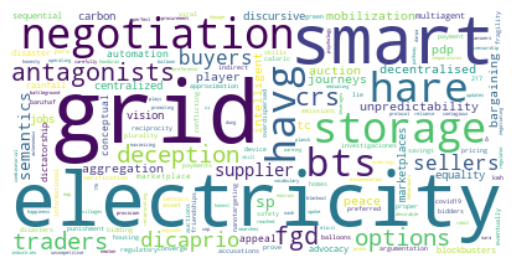



Community 4
Mykola Makhortykh
[]
Damian Trilling


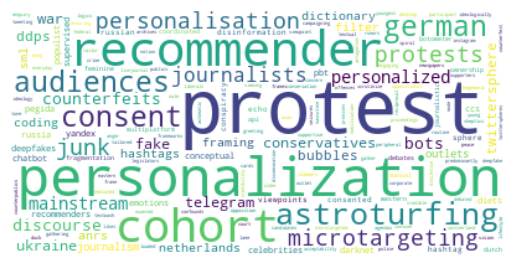



Community 12
Jurij Leskovec
Jon M. Kleinberg
Lada Adamic


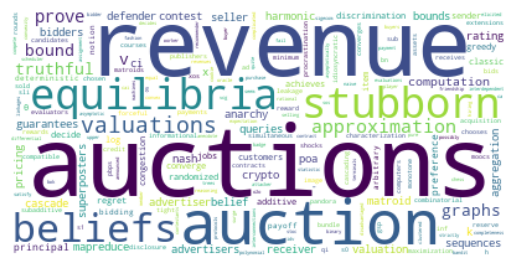



Community 18
Guido Caldarelli
Dirk Helbing
Matjaž Perc


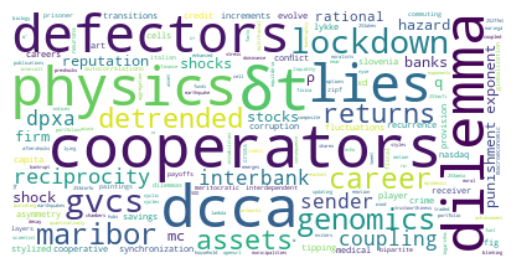



Community 57
Alessandro Vespignani
Nicolas Perra
Michele Tizzoni


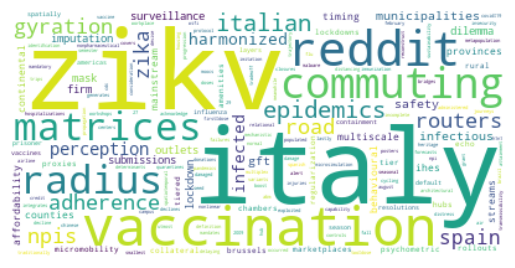



Community 1
[]
Emilio Zagheni
Ingmar Weber


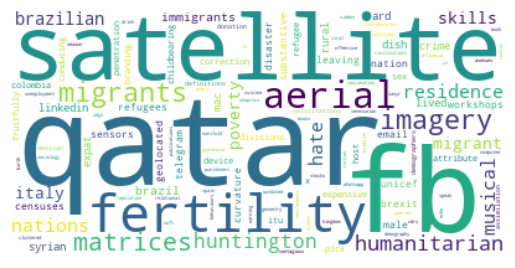



Community 6
John Joseph Horton
Michael S. Bernstein
[]


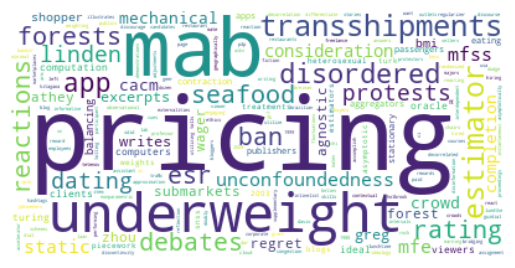



Community 116
[]
Siddharth Suri
Markus Mobius


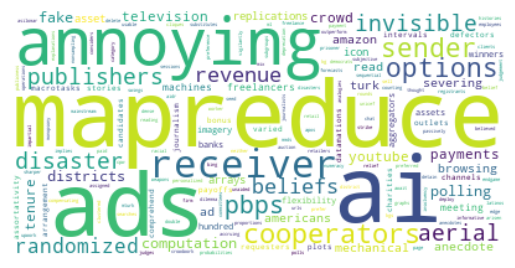



Community 28
nan
Zachary Steinert-threlkeld
[]


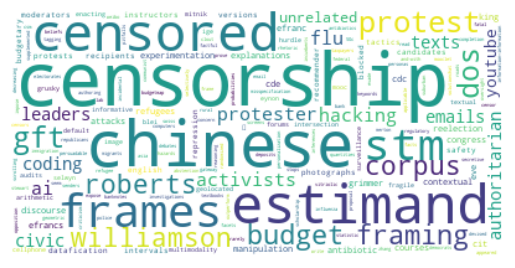

In [288]:
for i in top_9_communities.index:

    print(f'Community {i}')
    auth_top_3 = auth_top_3_dict[i]
    #print(f'Top 3 authors by degree: {auth_top_3}')
    for auth in auth_top_3:
        auth_name = G.nodes[auth]["name"]
        print(auth_name)
    wd = wordcloud.WordCloud(background_color="white").generate_from_frequencies(fdist_dict[i])
    plt.imshow(wd, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    print('\n')
